In [3]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import torch.nn as nn

ModuleNotFoundError: No module named 'torch'

In [2]:
#download
!curl https://zenodo.org/record/6532501/files/CESM_EA_SPI.nc?download=1 --output CESM_EA_SPI.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44.0M  100 44.0M    0     0   887k      0  0:00:50  0:00:50 --:--:-- 4509k


## Data visualization

In [22]:
file_name = 'CESM_EA_SPI.nc'
ds = xr.open_dataset(file_name)
spi = ds['spi']
spi

<xarray.DataArray 'spi' (time: 21612, lat: 13, lon: 20)>
[5619120 values with dtype=float64]
Coordinates:
  * time     (time) object '0400-01-16T12:00:00' ... '2200-12-16T12:00:00'
  * lat      (lat) float64 3.298 4.241 5.183 6.126 ... 11.78 12.72 13.66 14.61
  * lon      (lon) float64 23.75 25.0 26.25 27.5 28.75 ... 43.75 45.0 46.25 47.5
Attributes:
    title:          Standardized Precipitation Index
    standard_name:  atmosphere_water__standardized_precipitation_wetness_index
    long_name:      Standardized Precipitation Index
    units:          unitless
    valid_min:      -3.09
    valid_max:      3.09
    valid_range:    [-3.09  3.09]

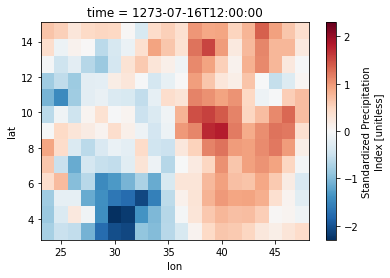

In [6]:
#plot spatial spi distribution for random time
time = np.random.randint(spi.shape[0])
spi2d = spi.isel(time=time)
spi2d.plot()

Text(0, 0.5, 'SPI')

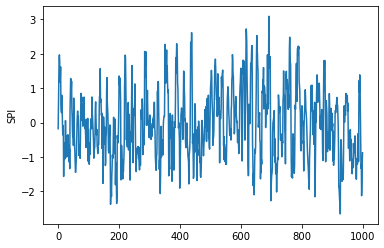

In [28]:
#plot spi time series at random location
lat = np.random.randint(spi.shape[1])
lon = np.random.randint(spi.shape[2])
k = np.random.randint(spi.shape[0]-1000)
plt.plot(spi[k:k+1000,lat,lon])
plt.ylabel('SPI')

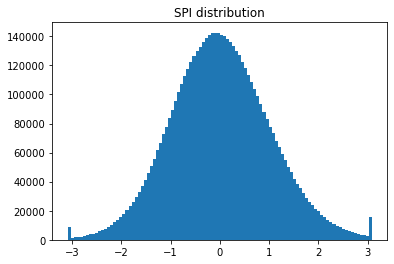

In [29]:
#plot overall spi distribution
plt.hist(np.array(spi).flatten(), bins=100)
plt.title('SPI distribution')
plt.show()

## Prepare data

In [3]:
def assemble_predictors_predictands(start_date, end_date, lead_time, dataset, num_input_time_steps):
    '''
    Args
    ----
    start_date (str): The start date for extraction. Important, put the trailing 0 at the beginning of year for dates before 1000 (e.g., '0400')
    end_date (str): The end date for extraction
    lead_time (int): The number of months between the predictor/predictand
    dataset (str): Either 'CESM' or 'ECMWF'
    num_input_time_steps (int): The number of time steps to use for each predictor samples
    '''    
    file_name = {'CESM': 'CESM_EA_SPI.nc', 'ECMWF': 'ECMWF_EA_SPI.nc'}[dataset]
    ds = xr.open_dataset(file_name)
    spi = ds['spi'].sel(time=slice(start_date,end_date))
    num_samples=spi.shape[0]
    #Stack and remove nans
    spi = np.stack([spi.values[n-num_input_time_steps:n] for n in range(num_input_time_steps, num_samples+1)])
    num_samples = spi.shape[0]
    spi[np.isnan(spi)] = 0
    #make sure we have floats in there
    X = spi.astype(np.float32)
    # select Y
    if dataset == 'ECMWF':
        start_date_plus_lead = pd.to_datetime(start_date) + pd.DateOffset(months=lead_time+num_input_time_steps-1)
        end_date_plus_lead = pd.to_datetime(end_date) + pd.DateOffset(months=lead_time)
    elif dataset == 'CESM':
        t_start=datetime.datetime(int(start_date.split('-')[0]),int(start_date.split('-')[1]),int(start_date.split('-')[2]))
        t_end=datetime.datetime(int(end_date.split('-')[0]),int(end_date.split('-')[1]),int(end_date.split('-')[2]))
        start_date_plus_lead = t_start + relativedelta(months=lead_time+num_input_time_steps-1)
        end_date_plus_lead = t_end + relativedelta(months=lead_time)
        if len(str(start_date_plus_lead.year))<4:
            start_date_plus_lead = '0'+start_date_plus_lead.strftime('%Y-%m-%d')
        elif len(str(start_date_plus_lead.year))==4:
            start_date_plus_lead = start_date_plus_lead.strftime('%Y-%m-%d')
        if len(str(end_date_plus_lead.year))<4:
            end_date_plus_lead = '0'+end_date_plus_lead.strftime('%Y-%m-%d')
        elif len(str(end_date_plus_lead.year))==4:
            end_date_plus_lead = end_date_plus_lead.strftime('%Y-%m-%d')
    subsetted_ds = ds['spi'].sel(time=slice(start_date_plus_lead, end_date_plus_lead))
    y = subsetted_ds.values.astype(np.float32)
    y[np.isnan(y)] = 0
    ds.close()
    X = np.swapaxes(X, 1,3)
    return X,y

class SPIDataset(Dataset):
    def __init__(self, predictors, predictands):
        self.predictors = predictors
        self.predictands = predictands
        assert self.predictors.shape[0] == self.predictands.shape[0], \
                   "The number of predictors must equal the number of predictands!"
    def __len__(self):
        return self.predictors.shape[0]
    def __getitem__(self, idx):
        return self.predictors[idx], self.predictands[idx]


In [4]:
num_input_time_steps = 3 
lead_time = 4

climate_model = 'CESM'
train_start_date = '0400-01-01'
train_end_date = '1800-12-31'

test_start_date = '1801-01-01'
test_end_date = '1978-12-31'

In [ ]:
train_predictors, train_predictands = assemble_predictors_predictands(train_start_date, train_end_date, lead_time, climate_model, num_input_time_steps)
test_predictors, test_predictands = assemble_predictors_predictands(test_start_date, test_end_date, lead_time, observations,num_input_time_steps)

train_dataset = SPIDataset(train_predictors, train_predictands)
test_dataset = SPIDataset(test_predictors, test_predictands)

trainloader = DataLoader(train_dataset, batch_size=100)
testloader = DataLoader(test_dataset, batch_size=100)

## Setup CNN

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_input_time_steps=1):
        """
        inputs
        -------
            num_input_time_steps        (int) : the number of input time
                                                steps in the predictor
        """
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=num_input_time_steps, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)   
        return x


## Train model

In [ ]:

def train_network(net, criterion, optimizer, trainloader, testloader, experiment_name, num_epochs=40):
    """
    inputs
    ------

      net               (nn.Module)   : the neural network architecture
      criterion         (nn)          : the loss function (i.e. root mean squared error)
      optimizer         (torch.optim) : the optimizer to use update the neural network 
                                        architecture to minimize the loss function
      trainloader       (torch.utils.data.DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the train dataset
      testloader        (torch.utils.data. DataLoader): dataloader that loads the
                                        predictors and predictands
                                        for the test dataset
      experiment_name   Name of the experiment (for visualization purposes)
      num_epochs        Number of epochs (default=40)


    outputs
    -------
      predictions (np.array), and saves the trained neural network as a .pt file
    """
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    net = net.to(device)
    best_loss = np.infty
    train_losses, test_losses = [], []

    for epoch in range(num_epochs):
        for mode, data_loader in [('train', trainloader), ('test', testloader)]:
            #Set the model to train mode to allow its weights to be updated
            #while training
            if mode == 'train':
                net.train()

            #Set the model to eval model to prevent its weights from being updated
            #while testing
            elif mode == 'test':
                net.eval()

            running_loss = 0.0
            for i, data in enumerate(data_loader):
                # get a mini-batch of predictors and predictands
                batch_predictors, batch_predictands = data
                batch_predictands = batch_predictands.to(device)
                batch_predictors = batch_predictors.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                #calculate the predictions of the current neural network
                predictions = net(batch_predictors)

                #quantify the quality of the predictions using a
                #loss function (aka criterion) that is differentiable
                loss = criterion(predictions, batch_predictands)

                if mode == 'train':
                    #the 'backward pass: calculates the gradients of each weight
                    #of the neural network with respect to the loss
                    loss.backward()

                #the optimizer updates the weights of the neural network
                #based on the gradients calculated above and the choice
                #of optimization algorithm
                optimizer.step()

                #Save the model weights that have the best performance!
                running_loss += loss.item()
                if running_loss < best_loss and mode == 'test':
                    best_loss = running_loss
                    torch.save(net.state_dict(), '{}.pt'.format(experiment_name))
        print('{} Set: Epoch {:02d}. loss: {:3f}'.format(mode, epoch+1, running_loss/len(data_loader)))
        if mode == 'train':
            train_losses.append(running_loss/len(data_loader))
        else:
            test_losses.append(running_loss/len(data_loader))
    return train_losses, test_losses


def test_network(testloader,experiment_name,num_input_time_steps):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    net = CNN(num_input_time_steps,False)
    net.load_state_dict(torch.load('{}.pt'.format(experiment_name)))
    net.eval()
    net.to(device)

    #the remainder of this notebook calculates the predictions of the best
    #saved model
    for i, data in enumerate(testloader):
        batch_predictors, batch_predictands = data
        batch_predictands = batch_predictands.to(device)
        batch_predictors = batch_predictors.to(device)

        batch_predictions = net(batch_predictors).squeeze()
        batch_predictions = batch_predictions.detach().cpu().numpy()
        try:   
            predictions = np.vstack((predictions, batch_predictions))
        except NameError:
            predictions = batch_predictions
        return predictions

In [ ]:
num_epochs = 100
net = CNN(num_input_time_steps=num_input_time_steps)
optimizer = optim.Adam(net.parameters(), lr=0.001)

experiment_name = "threelayerCNN_{}_{}_{}".format(train_start_date, train_end_date,lead_time)
train_losses, test_losses = train_network(net, nn.MSELoss(), optimizer, trainloader, testloader, experiment_name, num_epochs)


## Predict

In [22]:
pred = test_network(testloader,experiment_name,num_input_time_steps)

## Evaluate model

In [23]:
mse = mean_squared_error(pred, test_predictands)
print('MSE:', mse)

MSE: 1.0167857168018375
